# Generating Manuscript Figures

In [1]:
import numpy as np
import seaborn as sns;
import pandas as pd
import itertools
import keras
from numba import cuda

from math import log2, ceil
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from joblib import Parallel, delayed
import seaborn as sns

from pycpd import RigidRegistration
from pycpd import AffineRegistration
from pycpd import DeformableRegistration

In [2]:
from proglearn.sims import generate_gaussian_parity
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

## Functions

In [3]:
#Function to rotate distribution
def rotate(X, theta=0, dim=[0,1]):
    #dimensions to rotate
    Z = X[:, dim]
    
    #rotation
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to shear in the X direction
def shearX(X, s=0, dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    
    #shear
    R = np.array([[1, 0], [s, 1]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to shear in the Y direction
def shearY(X, s=0, dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    
    #shear
    R = np.array([[1, s], [0, 1]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to double shear in the X direction
def double_shearX(X, y, ss=(0,0) , dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    i,j = dim
    t,b = ss
    
    Z_top = Z[Z[:,j] >= 0]
    Z_bot = Z[Z[:,j] < 0]
    c_top = y[Z[:,j] >= 0]
    c_bot = y[Z[:,j] < 0]
    
    #shear
    R_top = np.array([[1, 0], [t, 1]])
    R_bot = np.array([[1, 0], [b, 1]])
    Z_top = Z_top @ R_top
    Z_bot = Z_bot @ R_bot
    
    #recombine
    Z = np.concatenate((Z_top, Z_bot))
    y = np.concatenate((c_top, c_bot))
    X[:, dim] = Z
    
    return X, y

#Function to divergently translate in the X direction
def div_translateX(X, y, t=0, dim=[0,1]):
    #dimensions to translate
    Z = X[:, dim]
    i,j = dim
    
    Z_top = Z[Z[:,j] >= 0]
    Z_bot = Z[Z[:,j] < 0]
    c_top = y[Z[:,j] >= 0]
    c_bot = y[Z[:,j] < 0]
    
    #stranslate
    Z_top[:, i] = Z_top[:, i] + t
    Z_bot[:, i] = Z_bot[:, i] - t
    
    #recombine
    Z = np.concatenate((Z_top, Z_bot))
    y = np.concatenate((c_top, c_bot))
    X[:, dim] = Z
    
    return X, y

#Function to twist data
def twist(X, tw=0, dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    
    #transform
    T = np.array([[0, 1], [1, 0]])
    Z = Z - tw * Z @ T  
    
    #recombine
    X[:, dim] = Z
    
    return X

## Adaptation Algorithms

In [4]:
def nearest_neighbor(src, dst, y_src, y_dst, class_aware=True):
    assert src.shape == dst.shape

    distances = np.zeros(y_src.shape)
    indices = np.zeros(y_src.shape, dtype=int)

    if class_aware:
        class1_src = np.where(y_src == 1)[0]
        class0_src = np.where(y_src == 0)[0]
        class1_dst = np.where(y_dst == 1)[0]
        class0_dst = np.where(y_dst == 0)[0]

        neigh_1 = NearestNeighbors(n_neighbors=1)
        neigh_1.fit(dst[class1_dst])
        distances_1, indices_1 = neigh_1.kneighbors(
            src[class1_src], return_distance=True
        )

        neigh_2 = NearestNeighbors(n_neighbors=1)
        neigh_2.fit(dst[class0_dst])
        distances_2, indices_2 = neigh_2.kneighbors(
            src[class0_src], return_distance=True
        )

        closest_class1 = class1_src[indices_1]
        closest_class0 = class0_src[indices_2]

        count = 0
        for i in class1_src:
            distances[i] = distances_1[count]
            indices[i] = closest_class1[count]
            count = count + 1

        count = 0
        for i in class0_src:
            distances[i] = distances_2[count]
            indices[i] = closest_class0[count]
            count = count + 1

    else:
        neigh = NearestNeighbors(n_neighbors=1)
        neigh.fit(dst)
        distances, indices = neigh.kneighbors(src, return_distance=True)

    return distances.ravel(), indices.ravel()


def best_fit_transform(A, B):
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[m - 1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R, centroid_A.T)

    # homogeneous transformation
    T = np.identity(m + 1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def icp(A, B, y_src, y_dst, init_pose=None, max_iterations=500, tolerance=1e-26):
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m + 1, A.shape[0]))
    dst = np.ones((m + 1, B.shape[0]))
    src[:m, :] = np.copy(A.T)
    dst[:m, :] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    imbalance = []

    class1_src = np.where(y_src == 1)[0]
    class0_src = np.where(y_src == 0)[0]
    class1_dst = np.where(y_dst == 1)[0]
    class0_dst = np.where(y_dst == 0)[0]

    imbalance.append(len(class1_src))
    imbalance.append(len(class0_src))
    imbalance.append(len(class1_dst))
    imbalance.append(len(class0_dst))

    mi = min(imbalance)

    X_1 = src[:, class1_src[0:mi]]
    X_2 = src[:, class0_src[0:mi]]

    src_subsample = np.concatenate((X_1, X_2), 1)
    y_src_sub = np.concatenate((np.ones(mi), np.zeros(mi)))

    X_1 = dst[:, class1_dst[0:mi]]
    X_2 = dst[:, class0_dst[0:mi]]
    dst_subsample = np.concatenate((X_1, X_2), 1)
    y_dst_sub = np.concatenate((np.ones(mi), np.zeros(mi)))

    for i in range(max_iterations):

        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(
            src_subsample[:m, :].T, dst_subsample[:m, :].T, y_src_sub, y_dst_sub
        )
        # distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T, y_src, y_dst)

        # compute the transformation between the current source and nearest destination points
        T, _, _ = best_fit_transform(
            src_subsample[:m, :].T, dst_subsample[:m, indices].T
        )
        # T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src_subsample = np.dot(T, src_subsample)
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    # T,_,_ = best_fit_transform(A, src[:m,:].T)

    return T, src, i


def cpd_reg(template, target, max_iter=200):    
    registration = AffineRegistration(X=target, Y=template, max_iterations=max_iter)
    deformed_template = registration.register(template)
    
    return deformed_template[0]

def nlr_reg(template, target, max_iter=200, alpha=0.75):    
    registration = DeformableRegistration(X=target, Y=template, alpha=alpha, max_iterations=max_iter)
    deformed_template = registration.register(template)
    
    return deformed_template[0]

## Simulation Data Generation

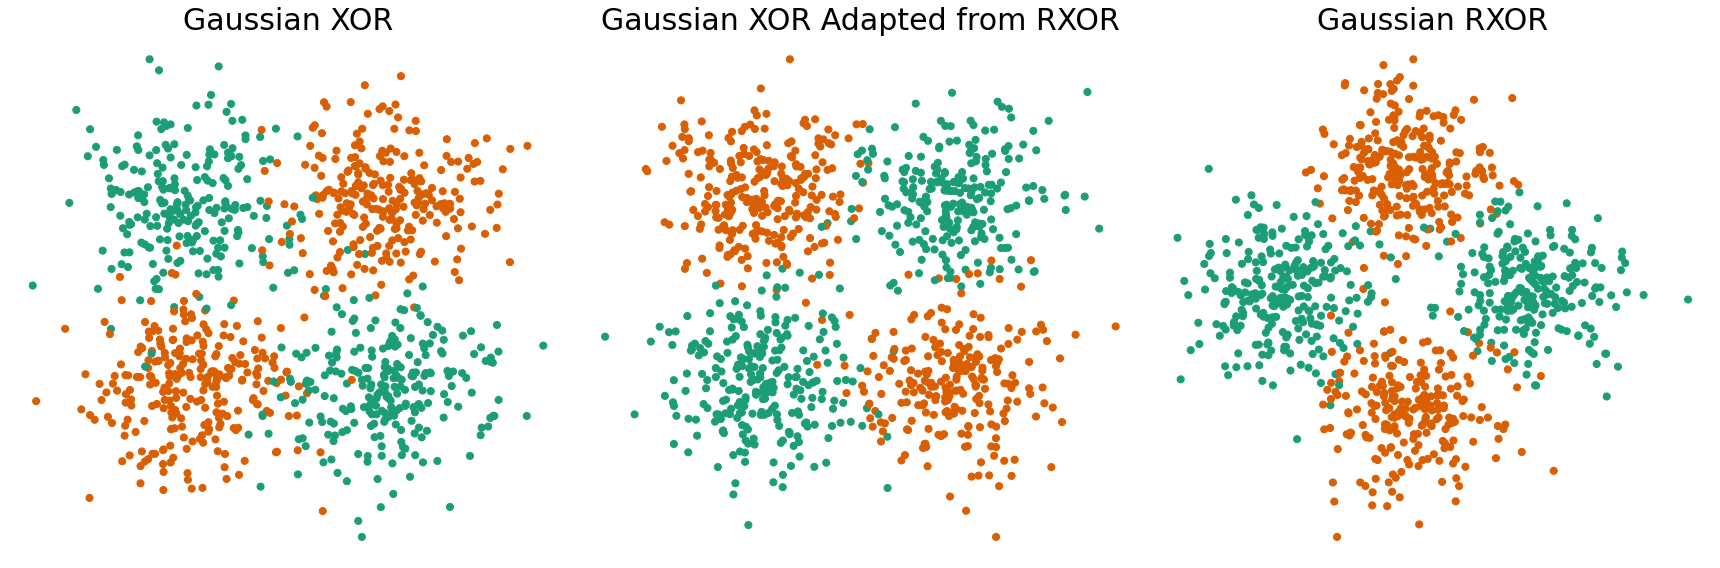

In [5]:
X_xor, y_xor = generate_gaussian_parity(1000)
X_rxor, y_rxor = generate_gaussian_parity(1000, angle_params=np.pi/4)
X_axor, y_axor = cpd_reg(X_rxor.copy(), X_xor.copy()), y_rxor.copy()

colors = sns.color_palette('Dark2', n_colors=2)
fig, ax = plt.subplots(1,3, figsize=(24,8))

clr = [colors[i] for i in y_xor]
ax[0].scatter(X_xor[:, 0], X_xor[:, 1], c=clr, s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Gaussian XOR', fontsize=30)
ax[0].axis('off')

clr = [colors[i] for i in y_axor]
ax[1].scatter(X_axor[:, 0], X_axor[:, 1], c=clr, s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Gaussian XOR Adapted from RXOR', fontsize=30)
ax[1].axis('off')

clr = [colors[i] for i in y_rxor]
ax[2].scatter(X_rxor[:, 0], X_rxor[:, 1], c=clr, s=50)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Gaussian RXOR', fontsize=30)
ax[2].axis('off')

plt.tight_layout()

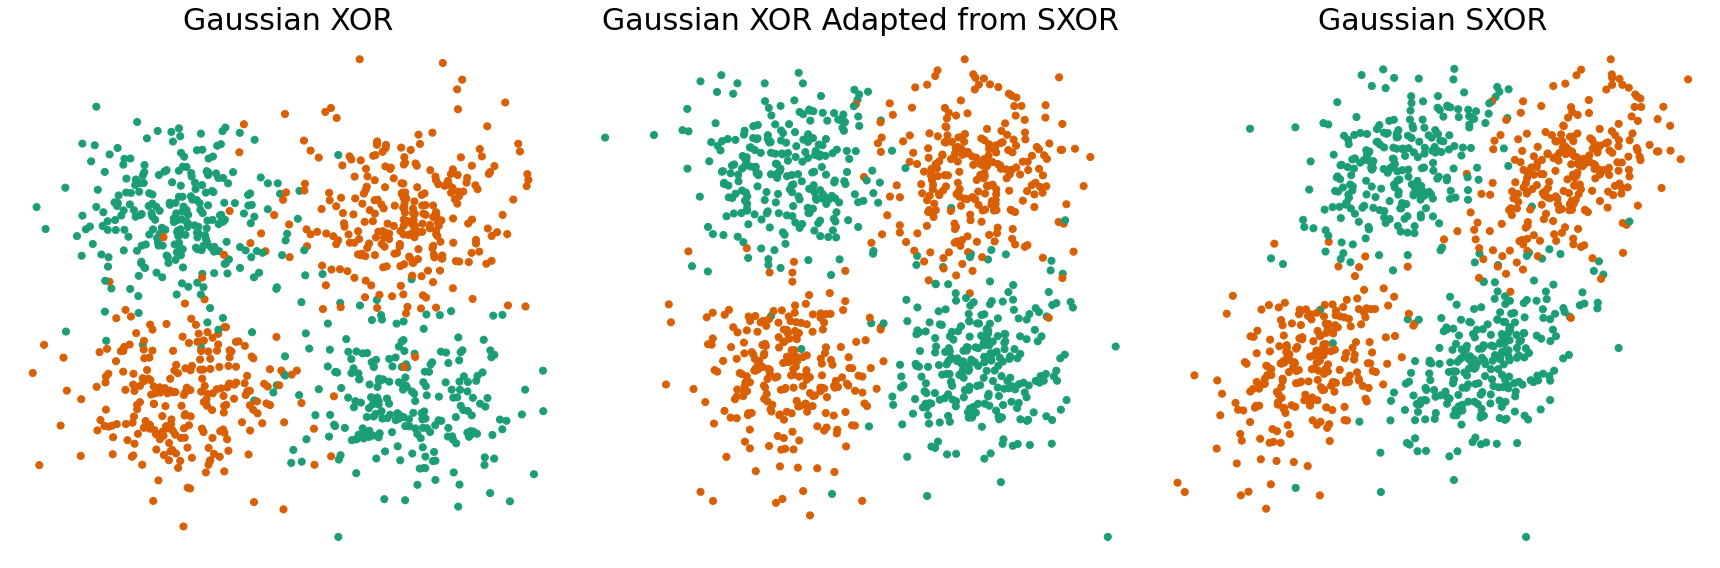

In [6]:
X_xor, y_xor = generate_gaussian_parity(1000)
X_rxor, y_rxor = generate_gaussian_parity(1000)
X_sxor, y_sxor = shearX(X_rxor, s=0.5), y_rxor
X_axor, y_axor = cpd_reg(X_sxor.copy(), X_xor.copy()), y_sxor.copy()

colors = sns.color_palette('Dark2', n_colors=2)
fig, ax = plt.subplots(1,3, figsize=(24,8))

clr = [colors[i] for i in y_xor]
ax[0].scatter(X_xor[:, 0], X_xor[:, 1], c=clr, s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Gaussian XOR', fontsize=30)
ax[0].axis('off')

clr = [colors[i] for i in y_axor]
ax[1].scatter(X_axor[:, 0], X_axor[:, 1], c=clr, s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Gaussian XOR Adapted from SXOR', fontsize=30)
ax[1].axis('off')

clr = [colors[i] for i in y_sxor]
ax[2].scatter(X_sxor[:, 0], X_sxor[:, 1], c=clr, s=50)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Gaussian SXOR', fontsize=30)
ax[2].axis('off')

plt.tight_layout()

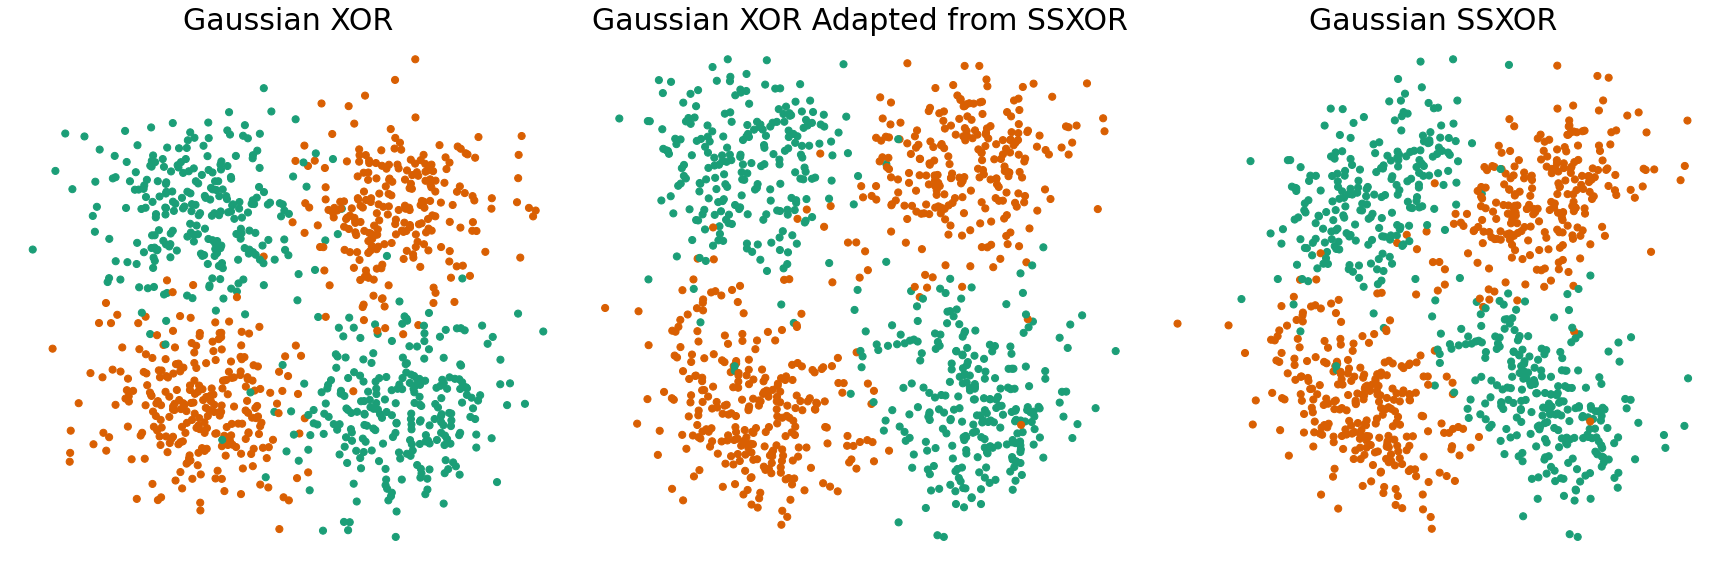

In [7]:
X_xor, y_xor = generate_gaussian_parity(1000)
X_rxor, y_rxor = generate_gaussian_parity(1000)
X_ssxor, y_ssxor = double_shearX(X_rxor, y_rxor, ss=(0.5,-0.5))
X_axor, y_axor = nlr_reg(X_ssxor.copy(), X_xor.copy()), y_ssxor.copy()

colors = sns.color_palette('Dark2', n_colors=2)
fig, ax = plt.subplots(1,3, figsize=(24,8))

clr = [colors[i] for i in y_xor]
ax[0].scatter(X_xor[:, 0], X_xor[:, 1], c=clr, s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Gaussian XOR', fontsize=30)
ax[0].axis('off')

clr = [colors[i] for i in y_axor]
ax[1].scatter(X_axor[:, 0], X_axor[:, 1], c=clr, s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Gaussian XOR Adapted from SSXOR', fontsize=30)
ax[1].axis('off')

clr = [colors[i] for i in y_ssxor]
ax[2].scatter(X_ssxor[:, 0], X_ssxor[:, 1], c=clr, s=50)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Gaussian SSXOR', fontsize=30)
ax[2].axis('off')

plt.tight_layout()

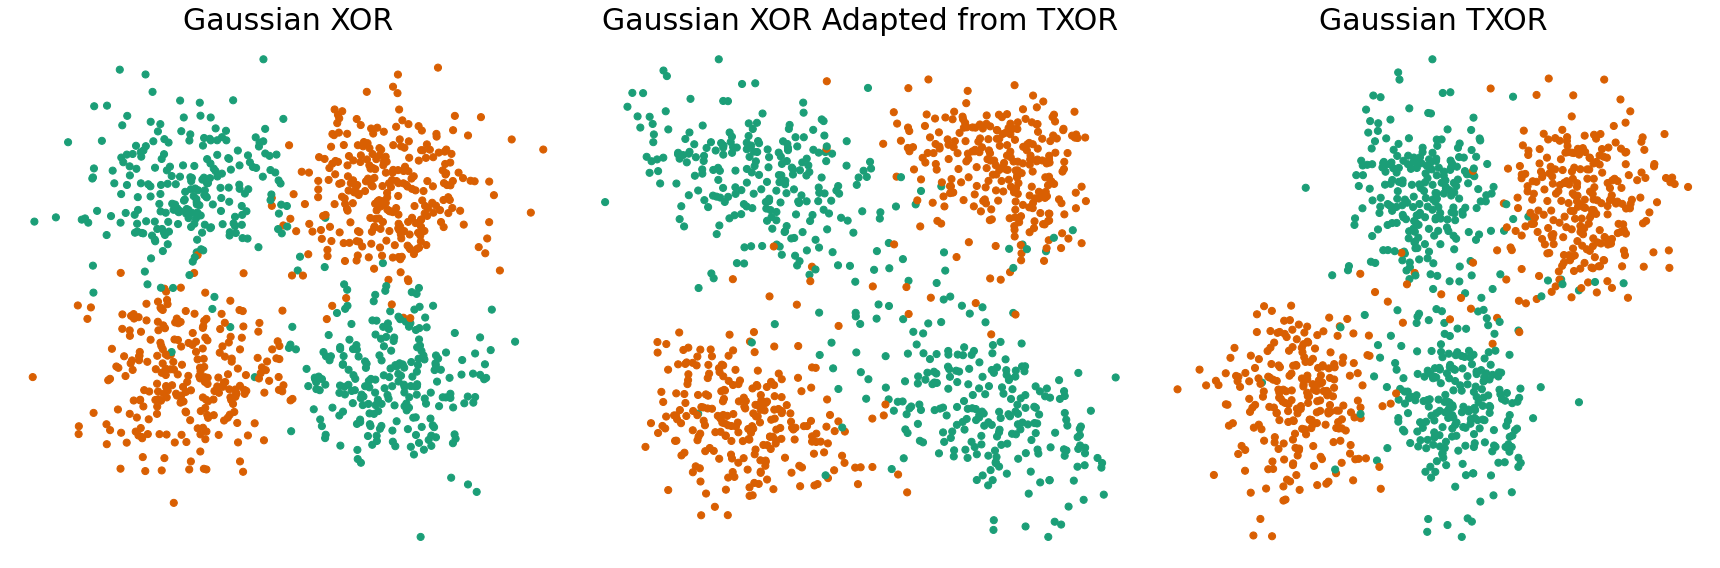

In [8]:
X_xor, y_xor = generate_gaussian_parity(1000)
X_rxor, y_rxor = generate_gaussian_parity(1000)
X_txor, y_txor = div_translateX(X_rxor, y_rxor, t=0.4)
X_axor, y_axor = nlr_reg(X_txor.copy(), X_xor.copy()), y_txor.copy()

colors = sns.color_palette('Dark2', n_colors=2)
fig, ax = plt.subplots(1,3, figsize=(24,8))

clr = [colors[i] for i in y_xor]
ax[0].scatter(X_xor[:, 0], X_xor[:, 1], c=clr, s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Gaussian XOR', fontsize=30)
ax[0].axis('off')

clr = [colors[i] for i in y_axor]
ax[1].scatter(X_axor[:, 0], X_axor[:, 1], c=clr, s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Gaussian XOR Adapted from TXOR', fontsize=30)
ax[1].axis('off')

clr = [colors[i] for i in y_txor]
ax[2].scatter(X_txor[:, 0], X_txor[:, 1], c=clr, s=50)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Gaussian TXOR', fontsize=30)
ax[2].axis('off')

plt.tight_layout()

# Rotation Experiment

In [9]:
def classifier_setup(max_depth=None):
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes": np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    naive_uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    
    return progressive_learner, uf, naive_uf

In [10]:
def experiment1(
    n_task1,
    n_task2,
    n_test=1000, 
    task1_angle=0,
    task2_angle=np.pi/2, 
    n_trees=10,
    max_depth=None,
    random_state=None,
    register_cpd=False,
    register_nlr=False,
    register_otp=False,
    register_icp=False,
):

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    #classifier setup
    progressive_learner, uf, naive_uf = classifier_setup(max_depth=max_depth)

    #task 1 data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #task 2 data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)
    
    #registration
    if register_cpd:
        X_task2 = cpd_reg(X_task2.copy(), X_task1.copy())
        
    if register_nlr:
        X_task2 = nlr_reg(X_task2.copy(), X_task1.copy())
    
    if register_icp:
        T, X_3, i = icp(X_task2.copy(), X_task1.copy(), y_task2.copy(), y_task1.copy())
        X_task2 = X_3.T[:, 0:2]

    #train and predict
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

    uf.add_task(X_task1, y_task1, num_transformers=2 * n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2 * n_trees)

    uf_task1 = uf.predict(test_task1, transformer_ids=[0], task_id=0)
    l2f_task1 = progressive_learner.predict(test_task1, task_id=0)

    errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
    errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)

    return errors

In [11]:
def bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_cpd=False, register_nlr=False, register_otp=False, register_icp=False):
    mean_te = np.zeros(len(angle_sweep), dtype=float)
    for ii, angle in enumerate(angle_sweep):
        error = np.array(
            Parallel(n_jobs=-1, verbose=1)(
                delayed(experiment1)(
                    task1_sample,
                    task2_sample,
                    task2_angle=angle,
                    max_depth=ceil(log2(task1_sample)),
                    register_cpd=register_cpd,
                    register_nlr=register_nlr,
                    register_otp=register_otp,
                    register_icp=register_icp
                )
                for _ in range(mc_rep)
            )
        )

        mean_te[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])

    return mean_te

### Experiment

In [14]:
#main hyperparameters
angle_sweep = range(0,91,10)
task1_sample = 100
task2_sample = 100
mc_rep = 1

In [15]:
mean_te1 = bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep)
mean_te2 = bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te3 = bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te4 = bte_v_angle(angle_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out

In [ ]:
colors = sns.color_palette('Dark2', n_colors=5)

sns.set_context("talk")
fig = plt.figure(constrained_layout=True, figsize=(25, 23))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
task = ["No adaptation", "CPD (Affine)", "ICP", "CPD (Nonlinear)"]
ax.plot(angle_sweep, mean_te1, c=colors[0], linewidth=6, label=task[0])
ax.plot(angle_sweep, mean_te2, c=colors[1], linewidth=6, label=task[1])
ax.plot(angle_sweep, mean_te3, c=colors[2], linewidth=6, label=task[2])
ax.plot(angle_sweep, mean_te4, c=colors[3], linewidth=6, label=task[3])
ax.set_xlabel("Angle of Rotation (Degrees)", fontsize=50)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=50)
ax.set_xticks(range(0,91,10))
ax.set_yticks([0.9, 1, 1.1, 1.2, 1.3])
ax.tick_params(labelsize=36)
ax.hlines(1, 0, 90, colors="grey", linestyles="dashed", linewidth=1.5)
ax.legend(loc="lower left", fontsize=40, frameon=False)
ax.set_title("BTE vs Angle", fontsize=50)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

# Shear Experiment

In [ ]:
def experiment2(
    n_task1,
    n_task2,
    n_test=1000, 
    task1_angle=0,
    task2_shear=1, 
    n_trees=10,
    max_depth=None,
    random_state=None,
    register_cpd=False,
    register_nlr=False,
    register_otp=False,
    register_icp=False,
):

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    #classifier setup
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes": np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    naive_uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )

    #task 1 data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #task 2 data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task1_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    
    #transform task 2
    X_task2 = shearX(X_task2, s=task2_shear)
    #test_task2 = shearX(test_task2, s=task2_shear)
    
    #registration
    if register_cpd:
        X_task2 = cpd_reg(X_task2.copy(), X_task1.copy())
        
    if register_nlr:
        X_task2 = nlr_reg(X_task2.copy(), X_task1.copy())
    
    if register_icp:
        T, X_3, i = icp(X_task2.copy(), X_task1.copy(), y_task2.copy(), y_task1.copy())
        X_task2 = X_3.T[:, 0:2]

    #train and predict
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

    uf.add_task(X_task1, y_task1, num_transformers=2 * n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2 * n_trees)

    uf_task1 = uf.predict(test_task1, transformer_ids=[0], task_id=0)
    l2f_task1 = progressive_learner.predict(test_task1, task_id=0)

    errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
    errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)

    return errors

In [ ]:
def bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=False, register_nlr=False, register_otp=False, register_icp=False):
    mean_te = np.zeros(len(shear_sweep), dtype=float)
    for ii, s in enumerate(shear_sweep):
        error = np.array(
            Parallel(n_jobs=-1, verbose=1)(
                delayed(experiment2)(
                    task1_sample,
                    task2_sample,
                    task2_shear=s,
                    max_depth=ceil(log2(task1_sample)),
                    register_cpd=register_cpd,
                    register_nlr=register_nlr,
                    register_otp=register_otp,
                    register_icp=register_icp
                )
                for _ in range(mc_rep)
            )
        )

        mean_te[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])

    return mean_te

### Experiment

In [ ]:
#main hyperparameters
shear_sweep = [x * 10**e for e in range(-2, 3) for x in [1, 2, 5]];
task1_sample = 100
task2_sample = 100
mc_rep = 1

In [ ]:
mean_te1 = bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep)
mean_te2 = bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te3 = bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te4 = bte_v_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

In [ ]:
colors = sns.color_palette('Dark2', n_colors=5)

sns.set_context("talk")
fig = plt.figure(constrained_layout=True, figsize=(25, 23))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
task = ["No adaptation", "CPD (Affine)", "ICP", "CPD (Nonlinear)"]
ax.plot(shear_sweep, mean_te1, c=colors[0], linewidth=6, label=task[0])
ax.plot(shear_sweep, mean_te2, c=colors[1], linewidth=6, label=task[1])
ax.plot(shear_sweep, mean_te3, c=colors[2], linewidth=6, label=task[2])
ax.plot(shear_sweep, mean_te4, c=colors[3], linewidth=6, label=task[3])
ax.set_xlabel("Shear Value (S)", fontsize=50)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=50)
ax.set_xscale('log')
ax.set_yticks([0.9, 1, 1.1, 1.2, 1.3])
ax.tick_params(labelsize=36)
ax.hlines(1, 0, 500, colors="grey", linestyles="dashed", linewidth=1.5)
ax.legend(loc="lower left", fontsize=40, frameon=False)
ax.set_title("BTE vs Shear", fontsize=50)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

# Double Shear Experiment

In [ ]:
def experiment3(
    n_task1,
    n_task2,
    n_test=1000, 
    task1_angle=0,
    task2_shear=1, 
    n_trees=10,
    max_depth=None,
    random_state=None,
    register_cpd=False,
    register_nlr=False,
    register_otp=False,
    register_icp=False,
):

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    #classifier setup
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes": np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    naive_uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )

    #task 1 data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #task 2 data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task1_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    
    #transform task 2
    X_task2, y_task2 = double_shearX(X_task2, y_task2, ss=(task2_shear, -task2_shear));
    test_task2, test_label_task2 = double_shearX(test_task2, test_label_task2, ss=(task2_shear, -task2_shear));
 
    #registration
    if register_cpd:
        X_task2 = cpd_reg(X_task2.copy(), X_task1.copy())
        
    if register_nlr:
        X_task2 = nlr_reg(X_task2.copy(), X_task1.copy())
    
    if register_icp:
        T, X_3, i = icp(X_task2.copy(), X_task1.copy(), y_task2.copy(), y_task1.copy())
        X_task2 = X_3.T[:, 0:2]

    #train and predict
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

    uf.add_task(X_task1, y_task1, num_transformers=2 * n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2 * n_trees)

    uf_task1 = uf.predict(test_task1, transformer_ids=[0], task_id=0)
    l2f_task1 = progressive_learner.predict(test_task1, task_id=0)

    errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
    errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)

    return errors

In [ ]:
def bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=False, register_nlr=False, register_otp=False, register_icp=False):
    mean_te = np.zeros(len(shear_sweep), dtype=float)
    for ii, s in enumerate(shear_sweep):
        error = np.array(
            Parallel(n_jobs=-1, verbose=1)(
                delayed(experiment3)(
                    task1_sample,
                    task2_sample,
                    task2_shear=s,
                    max_depth=ceil(log2(task1_sample)),
                    register_cpd=register_cpd,
                    register_nlr=register_nlr,
                    register_otp=register_otp,
                    register_icp=register_icp
                )
                for _ in range(mc_rep)
            )
        )

        mean_te[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])

    return mean_te

### Experiment

In [ ]:
#main hyperparameters
shear_sweep = [x * 10**e for e in range(-2, 3) for x in [1, 2, 5]];
task1_sample = 100
task2_sample = 100
mc_rep = 1

In [ ]:
mean_te1 = bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep)
mean_te2 = bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te3 = bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te4 = bte_v_double_shear(shear_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

In [ ]:
colors = sns.color_palette('Dark2', n_colors=5)

sns.set_context("talk")
fig = plt.figure(constrained_layout=True, figsize=(25, 23))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
task = ["No adaptation", "CPD (Affine)", "ICP", "CPD (Nonlinear)"]
ax.plot(shear_sweep, mean_te1, c=colors[0], linewidth=6, label=task[0])
ax.plot(shear_sweep, mean_te2, c=colors[1], linewidth=6, label=task[1])
ax.plot(shear_sweep, mean_te3, c=colors[2], linewidth=6, label=task[2])
ax.plot(shear_sweep, mean_te4, c=colors[3], linewidth=6, label=task[3])
ax.set_xlabel("Shear Value (SS)", fontsize=50)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=50)
ax.set_xscale('log')
ax.set_yticks([0.9, 1, 1.1, 1.2, 1.3])
ax.tick_params(labelsize=36)
ax.hlines(1, 0, 500, colors="grey", linestyles="dashed", linewidth=1.5)
ax.legend(loc="lower left", fontsize=40, frameon=False)
ax.set_title("BTE vs Double Shear", fontsize=50)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

# Divergent Translation Experiment

In [ ]:
def experiment4(
    n_task1,
    n_task2,
    n_test=1000, 
    task1_angle=0,
    task2_trans=1, 
    n_trees=10,
    max_depth=None,
    random_state=None,
    register_cpd=False,
    register_nlr=False,
    register_otp=False,
    register_icp=False,
):

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    #classifier setup
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes": np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )
    naive_uf = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
        default_decider_kwargs=default_decider_kwargs,
    )

    #task 1 data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #task 2 data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task1_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task1_angle)
    
    #transform task 2
    X_task2, y_task2 = div_translateX(X_task2, y_task2, t=task2_trans);
    #test_task2, test_label_task2 = double_shearX(test_task2, test_label_task2, ss=(task2_shear, -task2_shear));
 
    #registration
    if register_cpd:
        X_task2 = cpd_reg(X_task2.copy(), X_task1.copy())
        
    if register_nlr:
        X_task2 = nlr_reg(X_task2.copy(), X_task1.copy())
    
    if register_icp:
        T, X_3, i = icp(X_task2.copy(), X_task1.copy(), y_task2.copy(), y_task1.copy())
        X_task2 = X_3.T[:, 0:2]

    #train and predict
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

    uf.add_task(X_task1, y_task1, num_transformers=2 * n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2 * n_trees)

    uf_task1 = uf.predict(test_task1, transformer_ids=[0], task_id=0)
    l2f_task1 = progressive_learner.predict(test_task1, task_id=0)

    errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
    errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)

    return errors

In [ ]:
def bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_cpd=False, register_nlr=False, register_otp=False, register_icp=False):
    mean_te = np.zeros(len(trans_sweep), dtype=float)
    for ii, t in enumerate(trans_sweep):
        error = np.array(
            Parallel(n_jobs=-1, verbose=1)(
                delayed(experiment4)(
                    task1_sample,
                    task2_sample,
                    task2_trans=t,
                    max_depth=ceil(log2(task1_sample)),
                    register_cpd=register_cpd,
                    register_nlr=register_nlr,
                    register_otp=register_otp,
                    register_icp=register_icp
                )
                for _ in range(mc_rep)
            )
        )

        mean_te[ii] = np.mean(error[:, 0]) / np.mean(error[:, 1])

    return mean_te

### Experiment

In [ ]:
#main hyperparameters
trans_sweep = np.arange(0, 2.25, 0.25);
task1_sample = 100
task2_sample = 100
mc_rep = 1

In [ ]:
mean_te1 = bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep)
mean_te2 = bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_cpd=True)
mean_te3 = bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_icp=True)
mean_te4 = bte_v_translate(trans_sweep, task1_sample, task2_sample, mc_rep, register_nlr=True)

In [ ]:
colors = sns.color_palette('Dark2', n_colors=5)

sns.set_context("talk")
fig = plt.figure(constrained_layout=True, figsize=(25, 23))
gs = fig.add_gridspec(6, 6)
ax = fig.add_subplot(gs[:6, :6])
task = ["No adaptation", "CPD (Affine)", "ICP", "CPD (Nonlinear)"]
ax.plot(trans_sweep, mean_te1, c=colors[0], linewidth=6, label=task[0])
ax.plot(trans_sweep, mean_te2, c=colors[1], linewidth=6, label=task[1])
ax.plot(trans_sweep, mean_te3, c=colors[2], linewidth=6, label=task[2])
ax.plot(trans_sweep, mean_te4, c=colors[3], linewidth=6, label=task[3])
ax.set_xlabel("Translate Value (T)", fontsize=50)
ax.set_ylabel("Backward Transfer Efficiency (XOR)", fontsize=50)
ax.set_yticks([0.9, 1, 1.1, 1.2, 1.3])
ax.tick_params(labelsize=36)
ax.hlines(1, 0, 2, colors="grey", linestyles="dashed", linewidth=1.5)
ax.legend(loc="lower left", fontsize=40, frameon=False)
ax.set_title("BTE vs Divergent Translation", fontsize=50)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)